# Example 4: Symbolic Regression

The symbolic space is very dense, which means getting the correct symbolic formula (if existing at all) is a hard task. We will show how sentitive symbolic regression is, especially in the presence of noise. This is good or bad:

**Good**: One can easily find symbolic formulas that match with data quite well (within some tolerable epsilon). When one does not care about the exact symbolic formula, they might be happy with these approximate symbolic formulas that fit their data well. These approximate symbolic formulas provide some level of insight, have predictive power and are easy to compute.

**Bad**: It's hard to find the exact formula. When one does care about the exact formula, we either care about (i) its generalizability in future cases (like Newton's gravity), or (ii) fitting the clean data or solving a PDE as precise as machine precision. For case (i), it is open-ended and requires case-by-case analysis. For case (ii), we can get a (hopefully) clear signal of the correctness of a symbolic formula by noticing the loss to go down to near machine precision. We will use an example to demonstrate this below.

## Part I: Automated vs manual symbolic regression (How can we know that we get the exact formula?)

In [1]:
from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [2]:
# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);

train loss: 1.56e-01 | test loss: 1.63e-01 | reg: 2.56e+01 : 100%|██| 20/20 [00:18<00:00,  1.11it/s]


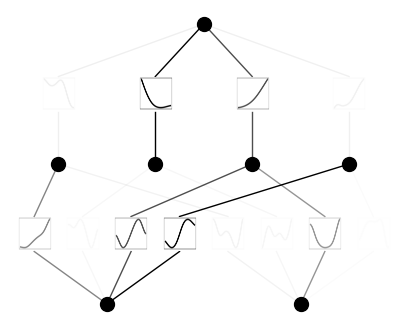

In [3]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [4]:
# sin appears at the top of the suggestion list, which is good!
model.suggest_symbolic(0,0,0)

function , r2
1/sqrt(x) , 0.9925534725189209
1/x , 0.992536723613739
arctan , 0.9925315380096436
tan , 0.9925286173820496
1/x^2 , 0.9924770593643188


('1/sqrt(x)',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9925534725189209)

In [5]:
# x^2 appears in the suggestion list (usually not top 1), but it is fine!
model.suggest_symbolic(0,1,0)

function , r2
gaussian , 0.721152663230896
abs , 0.6109872460365295
sin , 0.5223748683929443
x^2 , 0.5136656761169434
cosh , 0.5130663514137268


('gaussian',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.721152663230896)

In [6]:
# exp not even appears in the list (but note how high correlation of all these functions), which is sad!
model.suggest_symbolic(1,0,0)

function , r2
tanh , 0.9213166236877441
gaussian , 0.9190124273300171
sigmoid , 0.9157546162605286
arctan , 0.9112190008163452
x^3 , 0.906793475151062


('tanh',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9213166236877441)

In [7]:
# let's try suggesting more by changing topk. Exp should appear in the list
# But it's very unclear why should we prefer exp over others. All of them have quite high correlation with the learned spline.
model.suggest_symbolic(1,0,0,topk=15)

function , r2
tanh , 0.9213166236877441
gaussian , 0.9190124273300171
sigmoid , 0.9157546162605286
arctan , 0.9112190008163452
x^3 , 0.906793475151062
x^4 , 0.8717386722564697
exp , 0.8551774024963379
cosh , 0.8551774024963379
sgn , 0.8435732126235962
1/x^4 , 0.8426949977874756
1/x^3 , 0.8390956521034241
1/x^2 , 0.8326796293258667
1/x , 0.8183872699737549
tan , 0.8183774352073669
1/sqrt(x) , 0.8023388385772705


('tanh',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9213166236877441)

Let's train more! The loss goes down and the splines should be more exact

train loss: 6.24e-03 | test loss: 6.53e-03 | reg: 8.98e+00 : 100%|██| 20/20 [00:17<00:00,  1.15it/s]


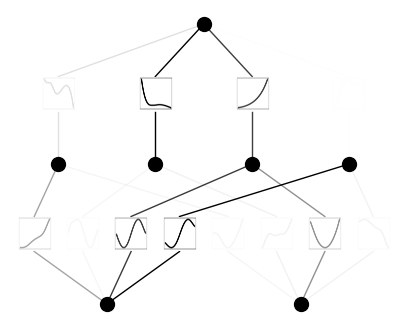

In [8]:
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

In [9]:
# sin appears at the top of the suggestion list, which is good!
model.suggest_symbolic(0,0,0)

function , r2
tan , 0.9935675859451294
arctanh , 0.9934589862823486
log , 0.9927238821983337
1/sqrt(x) , 0.9914506673812866
1/x , 0.9906012415885925


('tan',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9935675859451294)

In [10]:
# x^2 appears at the top of the suggestion list, which is good!
# But note how competitive cosh and gaussian are. They are also locally quadratic.
model.suggest_symbolic(0,1,0)

function , r2
gaussian , 0.9367237091064453
sin , 0.9366973042488098
x^2 , 0.9305729866027832
abs , 0.9273069500923157
cosh , 0.9128581881523132


('gaussian',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9367237091064453)

In [11]:
# exp appears at the top of the suggestion list, which is good!
model.suggest_symbolic(1,0,0)

function , r2
sin , 0.7850882411003113
tanh , 0.7560800313949585
gaussian , 0.7202386856079102
arctan , 0.7154971361160278
sgn , 0.7142574787139893


('sin',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.7850882411003113)

The takeaway is that symbolic regression is very sensitive to noise, so if we want to extract exact symbolic formulas from trained networks, the networks need to be trained to quite high accuracy!

In [12]:
# now let's replace every activation function with its top 1 symbolic suggestion. This is implmented in auto_symbolic()
model.auto_symbolic()

# if the user wants to constrain the symbolic space, they can pass in their symbolic libarary
# lib = ['sin', 'x^2', 'exp']
# model.auto_symbolic(lib=lib)

fixing (0,0,0) with tan, r2=0.9935675859451294
fixing (0,0,1) with sin, r2=0.9826238751411438
fixing (0,0,2) with sin, r2=0.9993470311164856
fixing (0,0,3) with sin, r2=0.9981896877288818
fixing (0,1,0) with gaussian, r2=0.9367237091064453
fixing (0,1,1) with x^3, r2=0.9615190029144287
fixing (0,1,2) with gaussian, r2=0.9991969466209412
fixing (0,1,3) with cosh, r2=0.9864839315414429
fixing (1,0,0) with sin, r2=0.7850882411003113
fixing (1,1,0) with gaussian, r2=0.9716032147407532
fixing (1,2,0) with cosh, r2=0.9999865293502808
fixing (1,3,0) with sigmoid, r2=0.9651917219161987


After retraining, we get (almost) machine precision! This is the winning signal that this formula is (very likely to be) exact!

train loss: 1.64e-02 | test loss: 1.62e-02 | reg: 9.30e+00 : 100%|██| 20/20 [00:07<00:00,  2.63it/s]


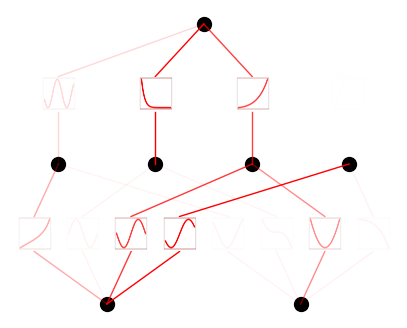

In [13]:
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

In [14]:
# obtaining symbolic formula
formula, variables = model.symbolic_formula()
formula[0]

0.03*sigmoid(-12.36*sin(2.61*x_1 - 9.39) - 0.07*cosh(1.32*x_2 + 1.4) + 8.28) + 0.01*sin(-3.75*tan(0.7*x_1 + 9.86) + 10.03 + 1.13*exp(-1.0*(-x_2 - 0.05)**2)) + 0.64*cosh(0.93*sin(3.15*x_1 - 0.e-2) + 11.13 - 9.86*exp(-0.1*x_2**2)) - 0.26 + 6.64*exp(-10.16*(-0.24*(-x_2 - 0.03)**3 - 0.15*sin(3.17*x_1 + 9.39) - 1)**2)

In [15]:
# if you want to rename your variables, you could use the "var" argument
formula, variables = model.symbolic_formula(var=['\\alpha','y'])
formula[0]

1.0*exp(1.0*y**2 + 1.0*sin(3.14*\alpha))

In [16]:
# one can even postprocess the formula (e.g., taking derivatives)
from sympy import *
diff(formula[0], variables[0])

3.14013671875*exp(1.0*y**2 + 1.0*sin(3.14*\alpha))*cos(3.14*\alpha)

When do we know the formula we guessed is wrong (not exact)? If the data is clean (no noise), we should see the training loss does not reach machine precision

In [17]:
# let's replace (0,1,0) with cosh
model.fix_symbolic(0,1,0,'cosh')

r2 is 0.999993562134913


tensor(1.0000)

train loss: 1.26e-03 | test loss: 1.28e-03 | reg: 2.93e+00 : 100%|██| 20/20 [00:03<00:00,  6.54it/s]


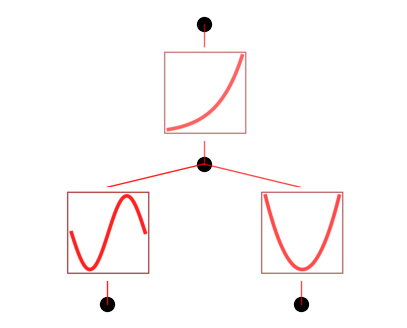

In [18]:
# this loss is stuck at around 1e-3 RMSE, which is good, but not machine precision.
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

## Part II: How hard (ill-defined) is symbolic regression, really?

In part I, we show how people can use KANs for symbolic regression, but caveat that we need to train KANs to quite high precision. This is not a problem specific to KANs though; this issue originates from symbolic regression. The space of symbolic formulas is actually quite dense, so tiny noise can make one symbolic formula transit to another. 

### 1D example: Adding noise to a bounded region sine

In [19]:
def toy(bound=1., noise=0., fun=lambda x: torch.sin(torch.pi*x)):

    num_pts = 101
    x = torch.linspace(-bound,bound,steps=num_pts)
    x = x[:,None]
    y = fun(x) + torch.normal(0,1,size=(num_pts,)) * noise
    dataset = {}
    dataset['train_input'] = dataset['test_input'] = x
    dataset['train_label'] = dataset['test_label'] = y
    model = KAN(width=[1,1], grid=5, k=3, seed=0, grid_range=(-bound,bound))
    model.train(dataset, opt="LBFGS", steps=20)
    model.suggest_symbolic(0,0,0)
    model.plot()

train loss: 2.79e-03 | test loss: 2.79e-03 | reg: 3.12e-01 : 100%|██| 20/20 [00:01<00:00, 13.38it/s]


function , r2
sin , 0.9999842278946689
gaussian , 0.9184406012010798
tanh , 0.8635381099424172
sigmoid , 0.8601324746874981
arctan , 0.845004037750832


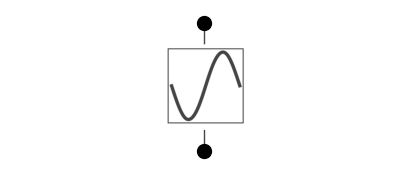

In [20]:
# when the function is whole range "bound=1."" (captures a whole period of sine) and has zero noise "noise=0."
# it is quite clear the function is clear
toy()

train loss: 9.30e-01 | test loss: 9.30e-01 | reg: 3.12e-01 : 100%|██| 20/20 [00:00<00:00, 40.68it/s]


function , r2
sin , 0.9999842278898873
gaussian , 0.9184406080128915
tanh , 0.8635381682633535
sigmoid , 0.8601325311561702
arctan , 0.8450040982073312


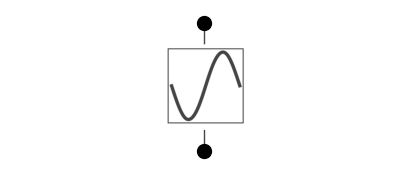

In [21]:
# even with large noise, sine can be revealed, yeah!
toy(noise=1.)

train loss: 9.30e-02 | test loss: 9.30e-02 | reg: 7.15e-01 : 100%|██| 20/20 [00:00<00:00, 43.08it/s]


function , r2
sin , 0.9999916591202906
arctan , 0.9999847147948822
tanh , 0.999984517365484
x , 0.9999796669306419
abs , 0.9999796669306419


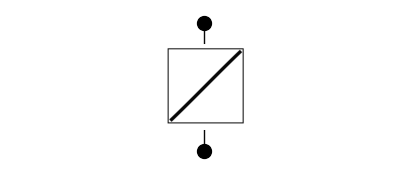

In [22]:
# but when bound is small and there is noise, it starts to screw up (at least becomes less clear why we should prefer sine)
toy(bound = 0.1, noise=0.1)

### Phase diagram of symbolic regression (how fratcal/chaotic is my phase diagram?)

#### mix three functions $f_1(x)={\rm sin}(x)$, $f_2(x)=x^2$, and $f_3(x)={\rm exp}(x)$ such that $f(x)=af_1(x)+bf_2(x)+(1-a-b)f_3(x)$. Symbolically regress $f(x)$.

In [23]:
def mix(a, b, bound=1):
    num_pts = 101
    x = torch.linspace(-bound,bound,steps=num_pts)
    x = x[:,None]
    y = a * torch.sin(x) + b * x**2 + (1-a-b) * torch.exp(x)
    dataset = {}
    dataset['train_input'] = dataset['test_input'] = x
    dataset['train_label'] = dataset['test_label'] = y
    model = KAN(width=[1,1], grid=10, k=3, seed=0, grid_range=(-bound,bound))
    model.train(dataset, opt="LBFGS", steps=20)
    return model.suggest_symbolic(0,0,0)[0]
    

In [24]:
mix(a=0.2, b=0.0)

train loss: 2.40e-06 | test loss: 2.40e-06 | reg: 2.64e-01 : 100%|██| 20/20 [00:00<00:00, 29.47it/s]


function , r2
cosh , 0.999997477547859
exp , 0.9999670134850122
sigmoid , 0.9999606621996252
tanh , 0.9999524925435431
1/x^4 , 0.9999517925552405


'cosh'

In [25]:
# let's do a phase diagram, which looks quite "fractal"
num = 11
a_arr = np.linspace(0,1,num=num)
b_arr = np.linspace(0,1,num=num)
sf_mat = np.empty((num,num), dtype='U8')

for i in range(num):
    for j in range(num):
        a = a_arr[i]; b = b_arr[j]
        sf_mat[i,j] = mix(a, b)

train loss: 2.77e-06 | test loss: 2.77e-06 | reg: 2.72e-01 : 100%|██| 20/20 [00:00<00:00, 43.39it/s]


function , r2
exp , 0.9999999999827021
cosh , 0.9999999999827017
tanh , 0.999973163748351
sigmoid , 0.9999497922899572
1/x^4 , 0.9999369992759012


train loss: 2.52e-06 | test loss: 2.52e-06 | reg: 2.45e-01 : 100%|██| 20/20 [00:01<00:00, 17.30it/s]


function , r2
cosh , 0.9999988787247418
x^4 , 0.9999910879853997
gaussian , 0.999967486241568
tanh , 0.9999518786252838
sigmoid , 0.999948450438625


train loss: 2.28e-06 | test loss: 2.28e-06 | reg: 2.18e-01 : 100%|██| 20/20 [00:00<00:00, 43.13it/s]


function , r2
cosh , 0.9999946575638085
x^3 , 0.9999164116905525
gaussian , 0.9997468080512466
x^4 , 0.9996076211798797
tanh , 0.9995835694860234


train loss: 2.04e-06 | test loss: 2.04e-06 | reg: 1.94e-01 : 100%|██| 20/20 [00:00<00:00, 39.90it/s]


function , r2
cosh , 0.9999854846669585
x^3 , 0.9988138920172807
gaussian , 0.9985227715662934
x^2 , 0.998477650070286
sin , 0.9981948138629363


train loss: 1.80e-06 | test loss: 1.80e-06 | reg: 1.71e-01 : 100%|██| 20/20 [00:00<00:00, 39.65it/s]


function , r2
cosh , 0.9999662581221136
x^2 , 0.9986097449347123
sin , 0.998284128651733
x^3 , 0.9936582971043266
gaussian , 0.9936463187510403


train loss: 1.55e-06 | test loss: 1.55e-06 | reg: 1.51e-01 : 100%|██| 20/20 [00:00<00:00, 44.84it/s]


function , r2
cosh , 0.9999418178114038
x^2 , 0.9987944480619438
sin , 0.9984323316332249
gaussian , 0.9949686832586251
tanh , 0.9764364382302457


train loss: 1.31e-06 | test loss: 1.31e-06 | reg: 1.36e-01 : 100%|██| 20/20 [00:00<00:00, 39.78it/s]


function , r2
cosh , 0.9999041816268858
x^2 , 0.9990436001283093
sin , 0.9986633245000535
gaussian , 0.9958810456319825
tanh , 0.9380270364085883


train loss: 1.07e-06 | test loss: 1.07e-06 | reg: 1.29e-01 : 100%|██| 20/20 [00:00<00:00, 40.74it/s]


function , r2
cosh , 0.9998655818685623
x^2 , 0.9993505000566273
sin , 0.9989811585960545
gaussian , 0.9916259900602326
x^4 , 0.9172564495092251


train loss: 8.32e-07 | test loss: 8.32e-07 | reg: 1.27e-01 : 100%|██| 20/20 [00:00<00:00, 44.57it/s]


function , r2
x^2 , 0.9996700824962792
sin , 0.9993888581205067
cosh , 0.998561267814873
gaussian , 0.9707186857583728
abs , 0.9254006963892939


train loss: 6.00e-07 | test loss: 6.00e-07 | reg: 1.30e-01 : 100%|██| 20/20 [00:00<00:00, 44.38it/s]


function , r2
x^2 , 0.9999132817985119
sin , 0.9994936051757877
gaussian , 0.9994851357951505
cosh , 0.987913942212583
abs , 0.933975094122013


train loss: 3.79e-07 | test loss: 3.79e-07 | reg: 1.38e-01 : 100%|██| 20/20 [00:00<00:00, 43.23it/s]


function , r2
x^2 , 0.9999999998837575
cosh , 0.9999099009608192
gaussian , 0.9997105669072212
sin , 0.9989290599804755
abs , 0.93740817498461


train loss: 2.58e-06 | test loss: 2.58e-06 | reg: 2.68e-01 : 100%|██| 20/20 [00:00<00:00, 27.79it/s]


function , r2
arctan , 0.9999798378098914
cosh , 0.9999771001456361
tanh , 0.9999633902076488
sigmoid , 0.9999541433147963
1/x^4 , 0.9999236487568766


train loss: 2.34e-06 | test loss: 2.34e-06 | reg: 2.40e-01 : 100%|██| 20/20 [00:00<00:00, 20.99it/s]


function , r2
cosh , 0.9999937207935639
x^4 , 0.9999862674170232
gaussian , 0.9999638602636551
sigmoid , 0.9999448387268524
x^3 , 0.9999438604212395


train loss: 2.10e-06 | test loss: 2.10e-06 | reg: 2.14e-01 : 100%|██| 20/20 [00:00<00:00, 40.36it/s]


function , r2
cosh , 0.9999949634057903
x^3 , 0.9998843971854673
gaussian , 0.9997599295163522
tanh , 0.9996162757398458
sigmoid , 0.9996147714224425


train loss: 1.86e-06 | test loss: 1.86e-06 | reg: 1.89e-01 : 100%|██| 20/20 [00:00<00:00, 50.75it/s]


function , r2
cosh , 0.999982696239627
x^2 , 0.9991234483879446
sin , 0.9988859253126088
x^3 , 0.9987772391387374
gaussian , 0.998656639925584


train loss: 1.61e-06 | test loss: 1.61e-06 | reg: 1.66e-01 : 100%|██| 20/20 [00:00<00:00, 43.78it/s]


function , r2
cosh , 0.9999905018303474
x^2 , 0.9992854342507987
sin , 0.998871759377929
gaussian , 0.9985721495291437
x^3 , 0.9939912670589373


train loss: 1.37e-06 | test loss: 1.37e-06 | reg: 1.45e-01 : 100%|██| 20/20 [00:00<00:00, 36.50it/s]


function , r2
cosh , 0.9999796806444573
x^2 , 0.999480532354729
sin , 0.9991909206588246
gaussian , 0.9964682981271429
tanh , 0.9772535252536733


train loss: 1.13e-06 | test loss: 1.13e-06 | reg: 1.29e-01 : 100%|██| 20/20 [00:00<00:00, 46.90it/s]


function , r2
cosh , 0.9999738670223917
x^2 , 0.9996973599778907
sin , 0.9994116683309964
gaussian , 0.9973545677199919
tanh , 0.9376915470857489


train loss: 8.85e-07 | test loss: 8.85e-07 | reg: 1.22e-01 : 100%|██| 20/20 [00:00<00:00, 43.78it/s]


function , r2
x^2 , 0.9998957469235318
cosh , 0.9998722722380837
sin , 0.9996590283030754
gaussian , 0.9939866829832639
abs , 0.9232648879118915


train loss: 6.46e-07 | test loss: 6.46e-07 | reg: 1.20e-01 : 100%|██| 20/20 [00:00<00:00, 36.61it/s]


function , r2
x^2 , 0.9999974059407801
sin , 0.999834148899939
cosh , 0.9962063866033833
gaussian , 0.9754127817001195
abs , 0.9311623016073874


train loss: 4.18e-07 | test loss: 4.18e-07 | reg: 1.24e-01 : 100%|██| 20/20 [00:00<00:00, 41.57it/s]


function , r2
x^2 , 0.9999226429006036
sin , 0.9998636426802294
cosh , 0.9997752175292851
gaussian , 0.999679958882009
abs , 0.9372397600766894


train loss: 2.23e-07 | test loss: 2.23e-07 | reg: 1.33e-01 : 100%|██| 20/20 [00:00<00:00, 40.07it/s]


function , r2
cosh , 0.9995568150249838
gaussian , 0.9993467471612426
sin , 0.9985870166410652
x^2 , 0.9984339446779963
abs , 0.9362895855226272


train loss: 2.41e-06 | test loss: 2.41e-06 | reg: 2.64e-01 : 100%|██| 20/20 [00:00<00:00, 50.70it/s]


function , r2
cosh , 0.9999974775415001
exp , 0.9999951134484997
sigmoid , 0.9999606621811076
tanh , 0.9999524925186463
1/x^4 , 0.9999517925693375


train loss: 2.16e-06 | test loss: 2.16e-06 | reg: 2.36e-01 : 100%|██| 20/20 [00:00<00:00, 38.09it/s]


function , r2
cosh , 0.9999987855303939
x^3 , 0.9999772484086487
x^4 , 0.9999697464110736
gaussian , 0.9999593591292381
sigmoid , 0.9999388880060787


train loss: 1.92e-06 | test loss: 1.92e-06 | reg: 2.09e-01 : 100%|██| 20/20 [00:00<00:00, 43.12it/s]


function , r2
cosh , 0.99999935535384
x^3 , 0.9998219698585193
gaussian , 0.9997659958370352
tanh , 0.9996382852712733
sigmoid , 0.999636745445751


train loss: 1.66e-06 | test loss: 1.66e-06 | reg: 1.84e-01 : 100%|██| 20/20 [00:01<00:00, 17.83it/s]


function , r2
cosh , 0.9999988957805453
x^2 , 0.9996199310076759
sin , 0.9994371092496096
gaussian , 0.9987635279928482
x^3 , 0.9986602848898886


train loss: 1.43e-06 | test loss: 1.43e-06 | reg: 1.60e-01 : 100%|██| 20/20 [00:00<00:00, 40.57it/s]


function , r2
cosh , 0.9999954784528895
x^2 , 0.9997669036986749
sin , 0.9994959364448105
gaussian , 0.9992839638818944
x^3 , 0.9941048878141949


train loss: 1.19e-06 | test loss: 1.19e-06 | reg: 1.39e-01 : 100%|██| 20/20 [00:00<00:00, 40.14it/s]


function , r2
x^2 , 0.9999057877413986
cosh , 0.9997878856454342
sin , 0.9997010374773055
gaussian , 0.9978271729275431
sigmoid , 0.9780411748220801


train loss: 9.43e-07 | test loss: 9.43e-07 | reg: 1.23e-01 : 100%|██| 20/20 [00:00<00:00, 42.49it/s]


function , r2
x^2 , 0.9999916810769826
sin , 0.9998540286212848
gaussian , 0.9985646631915182
cosh , 0.9978692658702253
tanh , 0.9372183456949574


train loss: 7.05e-07 | test loss: 7.05e-07 | reg: 1.15e-01 : 100%|██| 20/20 [00:00<00:00, 46.45it/s]


function , r2
x^2 , 0.9999411945915794
sin , 0.999917846530661
cosh , 0.9993168732975628
gaussian , 0.9961111289682559
abs , 0.9302392302167873


train loss: 4.75e-07 | test loss: 4.75e-07 | reg: 1.13e-01 : 100%|██| 20/20 [00:00<00:00, 48.74it/s]


function , r2
sin , 0.9997864168657743
x^2 , 0.9996579498087828
cosh , 0.9942754283755333
gaussian , 0.9798855202432393
abs , 0.9369096690204137


train loss: 2.64e-07 | test loss: 2.64e-07 | reg: 1.18e-01 : 100%|██| 20/20 [00:00<00:00, 43.76it/s]


function , r2
sin , 0.9992177278915768
x^2 , 0.999137470112453
gaussian , 0.999088490162276
cosh , 0.9988973034727238
abs , 0.9396624038444488


train loss: 1.78e-07 | test loss: 1.78e-07 | reg: 1.27e-01 : 100%|██| 20/20 [00:00<00:00, 45.43it/s]


function , r2
x^2 , 0.998540782190707
cosh , 0.998497783054037
sin , 0.9981679237204564
gaussian , 0.9980799911419045
abs , 0.9348151361956722


train loss: 2.22e-06 | test loss: 2.22e-06 | reg: 2.60e-01 : 100%|██| 20/20 [00:00<00:00, 47.65it/s]


function , r2
cosh , 0.9999930298639131
exp , 0.9999836112405796
tanh , 0.9999821515315185
x^4 , 0.9999746028947676
arctan , 0.9999713956244152


train loss: 1.98e-06 | test loss: 1.98e-06 | reg: 2.32e-01 : 100%|██| 20/20 [00:00<00:00, 47.28it/s]


function , r2
cosh , 0.9999962889824672
x^3 , 0.9999811150224204
gaussian , 0.9999534848375812
tanh , 0.9999336923279952
sigmoid , 0.9999305175966535


train loss: 1.74e-06 | test loss: 1.74e-06 | reg: 2.05e-01 : 100%|██| 20/20 [00:00<00:00, 40.82it/s]


function , r2
cosh , 0.9999962156472607
x^2 , 0.9998260034206992
gaussian , 0.9997664875004227
x^3 , 0.9997117036934391
sin , 0.9997113407524149


train loss: 1.49e-06 | test loss: 1.49e-06 | reg: 1.79e-01 : 100%|██| 20/20 [00:00<00:00, 47.64it/s]


function , r2
cosh , 0.9999544661515833
x^2 , 0.9999233768388777
sin , 0.9998096068574465
gaussian , 0.998846633386868
x^3 , 0.9984457355669536


train loss: 1.25e-06 | test loss: 1.25e-06 | reg: 1.55e-01 : 100%|██| 20/20 [00:00<00:00, 39.89it/s]


function , r2
x^2 , 0.9999875880501998
cosh , 0.9999623957580879
sin , 0.9998842247678139
gaussian , 0.9997446918456595
x^3 , 0.9939812278070211


train loss: 1.01e-06 | test loss: 1.01e-06 | reg: 1.33e-01 : 100%|██| 20/20 [00:00<00:00, 47.68it/s]


function , r2
x^2 , 0.9999658213074126
sin , 0.9998830954293118
cosh , 0.9991428566544741
gaussian , 0.9988921913945791
tanh , 0.9787975107817283


train loss: 7.68e-07 | test loss: 7.68e-07 | reg: 1.16e-01 : 100%|██| 20/20 [00:00<00:00, 44.81it/s]


function , r2
sin , 0.9999324078991241
x^2 , 0.9997596795941941
cosh , 0.9994865919109623
gaussian , 0.9994862477413593
tanh , 0.9365762760176262


train loss: 5.36e-07 | test loss: 5.36e-07 | reg: 1.08e-01 : 100%|██| 20/20 [00:00<00:00, 43.66it/s]


function , r2
sin , 0.9997548044475728
x^2 , 0.9992301995166885
cosh , 0.9979137733537407
gaussian , 0.9977997203751177
abs , 0.9377138311216435


train loss: 3.19e-07 | test loss: 3.19e-07 | reg: 1.07e-01 : 100%|██| 20/20 [00:00<00:00, 41.27it/s]


function , r2
sin , 0.9990790086224685
x^2 , 0.998306797086686
cosh , 0.9912197954445299
gaussian , 0.983836484418377
abs , 0.9422994090520702


train loss: 1.88e-07 | test loss: 1.88e-07 | reg: 1.12e-01 : 100%|██| 20/20 [00:00<00:00, 38.48it/s]


function , r2
sin , 0.9974240586295893
gaussian , 0.9973311148206122
x^2 , 0.9971996559803431
cosh , 0.9968911992725868
abs , 0.9402041148610969


train loss: 2.92e-07 | test loss: 2.92e-07 | reg: 1.21e-01 : 100%|██| 20/20 [00:00<00:00, 40.66it/s]


function , r2
cosh , 0.9964799073278351
x^2 , 0.9963340407057836
sin , 0.9959863127871974
gaussian , 0.9956440035977147
abs , 0.9297638765888608


train loss: 2.04e-06 | test loss: 2.04e-06 | reg: 2.57e-01 : 100%|██| 20/20 [00:01<00:00, 19.44it/s]


function , r2
x^4 , 0.9999894819511871
x^3 , 0.9999835048772354
tanh , 0.9999809889835496
cosh , 0.9999804113519436
sigmoid , 0.9999728460390712


train loss: 1.80e-06 | test loss: 1.80e-06 | reg: 2.28e-01 : 100%|██| 20/20 [00:00<00:00, 36.75it/s]


function , r2
cosh , 0.9999673825431549
gaussian , 0.9999462038064604
x^2 , 0.9999377574579958
x^3 , 0.999934739879401
tanh , 0.9999253640056137


train loss: 1.56e-06 | test loss: 1.56e-06 | reg: 2.00e-01 : 100%|██| 20/20 [00:00<00:00, 40.62it/s]


function , r2
x^2 , 0.9999856957320528
cosh , 0.9999806264360336
sin , 0.9999333905161271
gaussian , 0.9997629877627796
tanh , 0.9996615330714775


train loss: 1.31e-06 | test loss: 1.31e-06 | reg: 1.74e-01 : 100%|██| 20/20 [00:00<00:00, 42.76it/s]


function , r2
x^2 , 0.9999803474424048
sin , 0.9999690179361935
cosh , 0.9996537442008128
gaussian , 0.9989097397461996
tanh , 0.9985534483580678


train loss: 1.07e-06 | test loss: 1.07e-06 | reg: 1.50e-01 : 100%|██| 20/20 [00:00<00:00, 52.19it/s]


function , r2
sin , 0.9999726154715255
gaussian , 0.9999250404431426
x^2 , 0.9998623405070776
cosh , 0.9996561770567938
tanh , 0.9942785952521871


train loss: 8.35e-07 | test loss: 8.35e-07 | reg: 1.28e-01 : 100%|██| 20/20 [00:00<00:00, 48.08it/s]


function , r2
sin , 0.9999424641676066
gaussian , 0.9999091837427161
x^2 , 0.9995191008698547
cosh , 0.9978922471122651
tanh , 0.9795181094994256


train loss: 6.03e-07 | test loss: 6.03e-07 | reg: 1.10e-01 : 100%|██| 20/20 [00:00<00:00, 42.09it/s]


function , r2
sin , 0.9998135112170027
gaussian , 0.999787323738521
x^2 , 0.9987606438444635
cosh , 0.9982635098451202
abs , 0.9422869570493372


train loss: 3.87e-07 | test loss: 3.87e-07 | reg: 1.01e-01 : 100%|██| 20/20 [00:00<00:00, 40.12it/s]


function , r2
sin , 0.9992995819998103
gaussian , 0.9987377926584199
x^2 , 0.9973752641583749
cosh , 0.995255140131929
abs , 0.9455257642420224


train loss: 2.37e-07 | test loss: 2.37e-07 | reg: 1.00e-01 : 100%|██| 20/20 [00:00<00:00, 39.05it/s]


function , r2
sin , 0.9974728070753829
x^2 , 0.995416161237695
gaussian , 0.9867522256462564
cosh , 0.986582711416683
abs , 0.9468472932133176


train loss: 2.80e-07 | test loss: 2.80e-07 | reg: 1.05e-01 : 100%|██| 20/20 [00:00<00:00, 43.89it/s]


function , r2
sin , 0.9938672203947038
gaussian , 0.9937913539713064
x^2 , 0.9936057905336317
cosh , 0.9932430068628105
abs , 0.9381962721720656


train loss: 4.63e-07 | test loss: 4.63e-07 | reg: 1.16e-01 : 100%|██| 20/20 [00:00<00:00, 40.83it/s]


function , r2
x^2 , 0.992730560931046
sin , 0.9922829131306503
gaussian , 0.9916990159565282
cosh , 0.98563942691924
abs , 0.9212244844946261


train loss: 1.86e-06 | test loss: 1.86e-06 | reg: 2.53e-01 : 100%|██| 20/20 [00:00<00:00, 41.47it/s]


function , r2
cosh , 0.9999888112900659
x^2 , 0.9999849501568968
tanh , 0.9999760956345113
x^3 , 0.9999758615432004
sigmoid , 0.9999716645393338


train loss: 1.62e-06 | test loss: 1.62e-06 | reg: 2.24e-01 : 100%|██| 20/20 [00:00<00:00, 40.52it/s]


function , r2
x^2 , 0.9999870715347138
sin , 0.9999811871919927
cosh , 0.9999553343368358
gaussian , 0.9999383081018585
tanh , 0.9999177958840636


train loss: 1.38e-06 | test loss: 1.38e-06 | reg: 1.96e-01 : 100%|██| 20/20 [00:00<00:00, 44.48it/s]


function , r2
sin , 0.9999859303543726
gaussian , 0.9999644813363999
x^2 , 0.9999214589741492
tanh , 0.9996703332150525
sigmoid , 0.9996690041252987


train loss: 1.14e-06 | test loss: 1.14e-06 | reg: 1.69e-01 : 100%|██| 20/20 [00:00<00:00, 41.08it/s]


function , r2
sin , 0.9999802936975296
x^2 , 0.9997259928372615
cosh , 0.9993475620341137
gaussian , 0.9989573036832605
tanh , 0.9986543793643053


train loss: 9.05e-07 | test loss: 9.05e-07 | reg: 1.44e-01 : 100%|██| 20/20 [00:00<00:00, 44.49it/s]


function , r2
sin , 0.9999585866499787
gaussian , 0.9999486876810368
x^2 , 0.9992827278167005
cosh , 0.9988740875766842
tanh , 0.9946613426702609


train loss: 6.75e-07 | test loss: 6.75e-07 | reg: 1.22e-01 : 100%|██| 20/20 [00:00<00:00, 42.73it/s]


function , r2
sin , 0.9998822169169899
gaussian , 0.999878040103399
x^2 , 0.99837407546255
cosh , 0.9979460330489591
tanh , 0.9802089053769921


train loss: 4.60e-07 | test loss: 4.60e-07 | reg: 1.04e-01 : 100%|██| 20/20 [00:00<00:00, 42.62it/s]


function , r2
gaussian , 0.999597666676653
sin , 0.9995937068570286
x^2 , 0.99664915970953
cosh , 0.9958802001000374
abs , 0.9512847855771679


train loss: 2.98e-07 | test loss: 2.98e-07 | reg: 9.48e-02 : 100%|██| 20/20 [00:00<00:00, 46.20it/s]


function , r2
sin , 0.9984509165908535
gaussian , 0.9959578952120252
x^2 , 0.9937818028920754
cosh , 0.9907205081520056
abs , 0.9534651069741744


train loss: 2.89e-07 | test loss: 2.89e-07 | reg: 9.37e-02 : 100%|██| 20/20 [00:00<00:00, 40.23it/s]


function , r2
sin , 0.9943901136276602
x^2 , 0.990205343640921
gaussian , 0.987762675373181
cosh , 0.9761222166037805
abs , 0.9497419182649224


train loss: 4.40e-07 | test loss: 4.40e-07 | reg: 9.91e-02 : 100%|██| 20/20 [00:00<00:00, 43.16it/s]


function , r2
gaussian , 0.9876449536124641
sin , 0.9874566180838149
cosh , 0.9873751146532993
x^2 , 0.9871135812467379
abs , 0.9320312251409515


train loss: 6.40e-07 | test loss: 6.40e-07 | reg: 1.10e-01 : 100%|██| 20/20 [00:00<00:00, 47.36it/s]


function , r2
x^2 , 0.9873681256920457
sin , 0.9867104677131169
cosh , 0.9863604874844045
gaussian , 0.9859360750741196
x^4 , 0.9239128488596182


train loss: 1.69e-06 | test loss: 1.69e-06 | reg: 2.50e-01 : 100%|██| 20/20 [00:00<00:00, 38.33it/s]


function , r2
sin , 0.999990707616756
tanh , 0.9999723043366056
sigmoid , 0.9999701323519831
gaussian , 0.9999551813924956
x^2 , 0.9999522532756852


train loss: 1.44e-06 | test loss: 1.44e-06 | reg: 2.20e-01 : 100%|██| 20/20 [00:00<00:00, 20.47it/s]


function , r2
sin , 0.9999900693982379
gaussian , 0.9999311426065755
tanh , 0.9999145249443635
sigmoid , 0.9999130489202535
x^2 , 0.9998377031202675


train loss: 1.21e-06 | test loss: 1.21e-06 | reg: 1.92e-01 : 100%|██| 20/20 [00:00<00:00, 45.23it/s]


function , r2
sin , 0.9999862820440971
gaussian , 0.9997517753887365
tanh , 0.9996841983206314
sigmoid , 0.9996830107874256
x^2 , 0.999585767134396


train loss: 9.77e-07 | test loss: 9.77e-07 | reg: 1.65e-01 : 100%|██| 20/20 [00:00<00:00, 55.67it/s]


function , r2
sin , 0.9999745726295028
x^2 , 0.9990823277390866
gaussian , 0.9989945842715465
cosh , 0.9988728127858241
tanh , 0.9987539221752944


train loss: 7.49e-07 | test loss: 7.49e-07 | reg: 1.39e-01 : 100%|██| 20/20 [00:00<00:00, 40.60it/s]


function , r2
sin , 0.9999370198218576
x^2 , 0.9981115478889542
cosh , 0.9974772652014616
gaussian , 0.995731717057559
tanh , 0.9950291700743682


train loss: 5.36e-07 | test loss: 5.36e-07 | reg: 1.16e-01 : 100%|██| 20/20 [00:00<00:00, 44.68it/s]


function , r2
gaussian , 0.9998221482804251
sin , 0.9998030639266311
x^2 , 0.9962716348456105
cosh , 0.9957027344640318
tanh , 0.9808861574166389


train loss: 3.67e-07 | test loss: 3.67e-07 | reg: 9.76e-02 : 100%|██| 20/20 [00:00<00:00, 40.80it/s]


function , r2
gaussian , 0.9993158902101864
sin , 0.9992737234348714
x^2 , 0.9929134959392898
cosh , 0.9918352264630244
abs , 0.9605168885411256


train loss: 3.18e-07 | test loss: 3.18e-07 | reg: 8.81e-02 : 100%|██| 20/20 [00:00<00:00, 37.24it/s]


function , r2
sin , 0.9970616380122096
gaussian , 0.9966420291540972
x^2 , 0.9875208727310729
cosh , 0.983348154979657
abs , 0.9611248513995477


train loss: 4.31e-07 | test loss: 4.31e-07 | reg: 8.70e-02 : 100%|██| 20/20 [00:00<00:00, 43.04it/s]


function , r2
sin , 0.9888254509108924
x^2 , 0.981424420858435
gaussian , 0.9756945249179574
cosh , 0.9653653219988936
abs , 0.949892059404306


train loss: 6.17e-07 | test loss: 6.17e-07 | reg: 9.30e-02 : 100%|██| 20/20 [00:00<00:00, 42.47it/s]


function , r2
cosh , 0.9783739534751957
gaussian , 0.9779770648401149
sin , 0.9773944419005031
x^2 , 0.9772100499611249
abs , 0.9197221129892613


train loss: 8.36e-07 | test loss: 8.36e-07 | reg: 1.06e-01 : 100%|██| 20/20 [00:00<00:00, 45.89it/s]


function , r2
cosh , 0.9847797381605126
x^2 , 0.979881475095261
sin , 0.9789559646121901
gaussian , 0.9779176281844336
x^4 , 0.9285991153021671


train loss: 1.52e-06 | test loss: 1.52e-06 | reg: 2.46e-01 : 100%|██| 20/20 [00:00<00:00, 43.84it/s]


function , r2
sin , 0.9999930938197495
gaussian , 0.9999927495837864
tanh , 0.9999730056399402
sigmoid , 0.9999716131493217
arctan , 0.9999521920308199


train loss: 1.28e-06 | test loss: 1.28e-06 | reg: 2.17e-01 : 100%|██| 20/20 [00:00<00:00, 47.20it/s]


function , r2
sin , 0.9999916138797103
gaussian , 0.999926218584326
tanh , 0.9999191528924947
sigmoid , 0.9999179925256542
arctan , 0.9998352652530494


train loss: 1.05e-06 | test loss: 1.05e-06 | reg: 1.88e-01 : 100%|██| 20/20 [00:00<00:00, 49.52it/s]


function , r2
gaussian , 0.9999899760530466
sin , 0.9999866880205311
tanh , 0.9997096545485408
sigmoid , 0.9997086093190996
arctan , 0.9993950375881484


train loss: 8.25e-07 | test loss: 8.25e-07 | reg: 1.60e-01 : 100%|██| 20/20 [00:00<00:00, 50.16it/s]


function , r2
sin , 0.9999712618941392
gaussian , 0.9990277391373628
tanh , 0.9988653756689869
sigmoid , 0.9988643627333774
x^2 , 0.9979566871598838


train loss: 6.15e-07 | test loss: 6.15e-07 | reg: 1.34e-01 : 100%|██| 20/20 [00:00<00:00, 44.33it/s]


function , r2
gaussian , 0.9999414756950388
sin , 0.9999185788926284
x^2 , 0.9961768265523611
tanh , 0.9954056127804757
sigmoid , 0.9954045447762155


train loss: 4.42e-07 | test loss: 4.42e-07 | reg: 1.11e-01 : 100%|██| 20/20 [00:00<00:00, 36.47it/s]


function , r2
gaussian , 0.9997728550720852
sin , 0.9997168387512211
x^2 , 0.9928623326890238
cosh , 0.9921522541074415
tanh , 0.9815839509974684


train loss: 3.64e-07 | test loss: 3.64e-07 | reg: 9.13e-02 : 100%|██| 20/20 [00:00<00:00, 51.37it/s]


function , r2
gaussian , 0.9989709402248369
sin , 0.9988544685797407
x^2 , 0.9868026386831295
cosh , 0.985345236582632
abs , 0.9698770230380636


train loss: 4.35e-07 | test loss: 4.35e-07 | reg: 8.13e-02 : 100%|██| 20/20 [00:00<00:00, 40.11it/s]


function , r2
gaussian , 0.9949371389273981
sin , 0.9949107782356766
x^2 , 0.977112955292746
cosh , 0.9716178500832297
abs , 0.967722640360993


train loss: 6.03e-07 | test loss: 6.03e-07 | reg: 8.00e-02 : 100%|██| 20/20 [00:00<00:00, 43.30it/s]


function , r2
sin , 0.9790424824765466
gaussian , 0.9715243025795919
x^2 , 0.9671692490974791
cosh , 0.9450165956953308
abs , 0.9448625902159359


train loss: 8.07e-07 | test loss: 8.07e-07 | reg: 8.69e-02 : 100%|██| 20/20 [00:00<00:00, 43.17it/s]


function , r2
cosh , 0.965461717507565
x^2 , 0.9648932341203752
sin , 0.963856710506799
gaussian , 0.9636801162210671
x^4 , 0.9002751610118467


train loss: 1.03e-06 | test loss: 1.03e-06 | reg: 1.03e-01 : 100%|██| 20/20 [00:00<00:00, 41.77it/s]


function , r2
cosh , 0.9807409640082864
x^2 , 0.9699721931104404
sin , 0.9677166767908957
gaussian , 0.9394860427747876
x^4 , 0.9351858394996657


train loss: 1.36e-06 | test loss: 1.36e-06 | reg: 2.43e-01 : 100%|██| 20/20 [00:00<00:00, 44.90it/s]


function , r2
gaussian , 0.9999978669498215
sin , 0.9999956722754607
tanh , 0.9999799263714397
sigmoid , 0.9999789216022107
arctan , 0.9999642054598574


train loss: 1.13e-06 | test loss: 1.13e-06 | reg: 2.13e-01 : 100%|██| 20/20 [00:00<00:00, 44.99it/s]


function , r2
sin , 0.9999943906884494
tanh , 0.9999343640823076
sigmoid , 0.9999334248881454
gaussian , 0.9999249439932951
arctan , 0.9998684985487326


train loss: 9.03e-07 | test loss: 9.03e-07 | reg: 1.84e-01 : 100%|██| 20/20 [00:00<00:00, 45.74it/s]


function , r2
sin , 0.9999896507243767
tanh , 0.9997526274283742
sigmoid , 0.9997517092998544
gaussian , 0.9997514568009086
arctan , 0.9994994651669644


train loss: 6.94e-07 | test loss: 6.94e-07 | reg: 1.56e-01 : 100%|██| 20/20 [00:00<00:00, 45.29it/s]


function , r2
gaussian , 0.9999899485873852
sin , 0.9999314322918655
tanh , 0.9990030069449396
sigmoid , 0.9990020609332764
arctan , 0.9981096381936067


train loss: 5.19e-07 | test loss: 5.19e-07 | reg: 1.30e-01 : 100%|██| 20/20 [00:00<00:00, 36.49it/s]


function , r2
gaussian , 0.9999536171672674
sin , 0.9999094157336442
tanh , 0.9958217326666846
sigmoid , 0.9958206863529286
x^2 , 0.9932659752647721


train loss: 4.21e-07 | test loss: 4.21e-07 | reg: 1.06e-01 : 100%|██| 20/20 [00:00<00:00, 49.72it/s]


function , r2
gaussian , 0.9997544064398111
sin , 0.9996390145601096
x^2 , 0.9876782817075724
cosh , 0.986829120472927
tanh , 0.9823615338330297


train loss: 4.54e-07 | test loss: 4.54e-07 | reg: 8.52e-02 : 100%|██| 20/20 [00:00<00:00, 42.86it/s]


function , r2
gaussian , 0.9985268503112813
sin , 0.9983499410484818
abs , 0.9785902377362155
x^2 , 0.9771995020822951
cosh , 0.9752846715582264


train loss: 5.93e-07 | test loss: 5.93e-07 | reg: 7.45e-02 : 100%|██| 20/20 [00:00<00:00, 40.78it/s]


function , r2
gaussian , 0.991738617202277
sin , 0.9916999095855713
abs , 0.9717770596320756
x^2 , 0.9601566417330277
cosh , 0.9530802418693475


train loss: 7.85e-07 | test loss: 7.85e-07 | reg: 7.31e-02 : 100%|██| 20/20 [00:00<00:00, 44.58it/s]


function , r2
sin , 0.9620464258065169
gaussian , 0.9582876791641027
x^2 , 0.9445008625317239
cosh , 0.9430687242552336
abs , 0.9308710215935037


train loss: 9.96e-07 | test loss: 9.96e-07 | reg: 8.13e-02 : 100%|██| 20/20 [00:00<00:00, 43.11it/s]


function , r2
cosh , 0.9480750122921905
x^2 , 0.9456250628531494
sin , 0.9445956284973298
gaussian , 0.9434289429080119
x^4 , 0.9009688699792165


train loss: 1.22e-06 | test loss: 1.22e-06 | reg: 1.02e-01 : 100%|██| 20/20 [00:00<00:00, 37.36it/s]


function , r2
cosh , 0.9766929896410047
x^2 , 0.957514493788183
sin , 0.9559851348570871
x^4 , 0.9438827362855521
gaussian , 0.9167827938895323


train loss: 1.20e-06 | test loss: 1.20e-06 | reg: 2.39e-01 : 100%|██| 20/20 [00:00<00:00, 46.26it/s]


function , r2
sin , 0.9999984333249491
sigmoid , 0.9999901865767792
arctan , 0.9999829580110535
gaussian , 0.9999746546393077
tanh , 0.9999393123160958


train loss: 9.82e-07 | test loss: 9.82e-07 | reg: 2.10e-01 : 100%|██| 20/20 [00:00<00:00, 43.17it/s]


function , r2
sin , 0.9999977984107461
gaussian , 0.999996383890805
tanh , 0.9999585593099201
sigmoid , 0.9999577735635269
arctan , 0.9999150645734015


train loss: 7.75e-07 | test loss: 7.75e-07 | reg: 1.80e-01 : 100%|██| 20/20 [00:00<00:00, 43.96it/s]


function , r2
gaussian , 0.9999953796079631
sin , 0.9999944856461577
tanh , 0.9998140271258696
sigmoid , 0.9998132139651115
arctan , 0.9996263187286749


train loss: 5.99e-07 | test loss: 5.99e-07 | reg: 1.52e-01 : 100%|██| 20/20 [00:00<00:00, 39.44it/s]


function , r2
sin , 0.9999799131978417
tanh , 0.9991760870939851
sigmoid , 0.999175206451367
gaussian , 0.9991099365080184
arctan , 0.9984657428834645


train loss: 4.86e-07 | test loss: 4.86e-07 | reg: 1.25e-01 : 100%|██| 20/20 [00:00<00:00, 56.80it/s]


function , r2
gaussian , 0.9999683931970753
sin , 0.9999135788767782
tanh , 0.996308913203486
sigmoid , 0.9963078955424317
arctan , 0.9939227717854873


train loss: 4.85e-07 | test loss: 4.85e-07 | reg: 1.00e-01 : 100%|██| 20/20 [00:00<00:00, 44.41it/s]


function , r2
gaussian , 0.9997689201745247
sin , 0.9995873145216307
abs , 0.9849023647718247
tanh , 0.9833009867719864
sigmoid , 0.9832997013656896


train loss: 5.93e-07 | test loss: 5.93e-07 | reg: 7.91e-02 : 100%|██| 20/20 [00:00<00:00, 47.72it/s]


function , r2
gaussian , 0.9982643783383393
sin , 0.9977962501289016
abs , 0.9854353082947718
x^2 , 0.9624423927207054
cosh , 0.9600011409875004


train loss: 7.70e-07 | test loss: 7.70e-07 | reg: 6.75e-02 : 100%|██| 20/20 [00:00<00:00, 39.11it/s]


function , r2
sin , 0.9870493767685123
gaussian , 0.9870320319171259
abs , 0.9705633369555351
x^2 , 0.932694450295423
cosh , 0.9237291936352401


train loss: 9.74e-07 | test loss: 9.74e-07 | reg: 6.60e-02 : 100%|██| 20/20 [00:00<00:00, 42.96it/s]


function , r2
sin , 0.9329023836770476
gaussian , 0.9251125534459796
x^2 , 0.9090404451604721
cosh , 0.9075530370365199
abs , 0.902215514501183


train loss: 1.19e-06 | test loss: 1.19e-06 | reg: 7.68e-02 : 100%|██| 20/20 [00:00<00:00, 45.43it/s]


function , r2
cosh , 0.936942764457975
x^2 , 0.9195925986987522
sin , 0.9179859981970137
gaussian , 0.916197691863038
x^4 , 0.9043637756591075


train loss: 1.42e-06 | test loss: 1.42e-06 | reg: 1.03e-01 : 100%|██| 20/20 [00:00<00:00, 42.15it/s]


function , r2
cosh , 0.9746783379118565
x^4 , 0.9547067294869719
x^2 , 0.9426800819283715
sin , 0.9405877648417602
gaussian , 0.9047220443136558


train loss: 1.06e-06 | test loss: 1.06e-06 | reg: 2.36e-01 : 100%|██| 20/20 [00:00<00:00, 44.17it/s]


function , r2
sin , 0.9999998722503725
tanh , 0.9999959867450359
sigmoid , 0.9999953377679788
arctan , 0.9999901647899601
gaussian , 0.9999791487269069


train loss: 8.56e-07 | test loss: 8.56e-07 | reg: 2.06e-01 : 100%|██| 20/20 [00:00<00:00, 50.53it/s]


function , r2
sin , 0.9999997233652407
tanh , 0.9999795491992056
sigmoid , 0.9999788713253935
arctan , 0.9999539297010896
gaussian , 0.9999367314200862


train loss: 6.79e-07 | test loss: 6.79e-07 | reg: 1.77e-01 : 100%|██| 20/20 [00:00<00:00, 47.96it/s]


function , r2
sin , 0.9999983352488726
gaussian , 0.9999608456659727
tanh , 0.9998803010371731
sigmoid , 0.9998795700743581
arctan , 0.9997532798065882


train loss: 5.56e-07 | test loss: 5.56e-07 | reg: 1.48e-01 : 100%|██| 20/20 [00:00<00:00, 47.37it/s]


function , r2
sin , 0.9999886905327071
gaussian , 0.9999526296594224
tanh , 0.9993739474035951
sigmoid , 0.9993731243691055
arctan , 0.998837883424404


train loss: 5.28e-07 | test loss: 5.28e-07 | reg: 1.20e-01 : 100%|██| 20/20 [00:00<00:00, 47.09it/s]


function , r2
gaussian , 0.9999347944113626
sin , 0.9999299845850768
tanh , 0.9968744391727294
sigmoid , 0.9968734504088798
arctan , 0.9949201894762312


train loss: 6.08e-07 | test loss: 6.08e-07 | reg: 9.51e-02 : 100%|██| 20/20 [00:00<00:00, 34.26it/s]


function , r2
gaussian , 0.9997595833681479
sin , 0.9993617636896577
abs , 0.9889704797728257
sigmoid , 0.9844737269360767
tanh , 0.9844552121850878


train loss: 7.61e-07 | test loss: 7.61e-07 | reg: 7.30e-02 : 100%|██| 20/20 [00:00<00:00, 39.79it/s]


function , r2
gaussian , 0.9979451890061467
sin , 0.9972568796736283
abs , 0.9882338451079785
x^2 , 0.9400830044171552
cosh , 0.9380462665721708


train loss: 9.51e-07 | test loss: 9.51e-07 | reg: 6.06e-02 : 100%|██| 20/20 [00:00<00:00, 42.43it/s]


function , r2
sin , 0.9805383456413282
gaussian , 0.9793534545721814
abs , 0.9588682058685749
x^2 , 0.8881789600114199
cosh , 0.8769912910873774


train loss: 1.16e-06 | test loss: 1.16e-06 | reg: 5.94e-02 : 100%|██| 20/20 [00:00<00:00, 42.80it/s]


function , r2
sin , 0.8848700744056857
gaussian , 0.8765425797595888
x^2 , 0.854821484894479
cosh , 0.8535224650797281
abs , 0.8493986649063162


train loss: 1.38e-06 | test loss: 1.38e-06 | reg: 7.70e-02 : 100%|██| 20/20 [00:00<00:00, 48.12it/s]


function , r2
cosh , 0.9268644000446836
x^4 , 0.9112716246650874
x^2 , 0.8865324039130013
sin , 0.8842948895377678
gaussian , 0.8094804211038418


train loss: 1.60e-06 | test loss: 1.60e-06 | reg: 1.05e-01 : 100%|██| 20/20 [00:00<00:00, 44.20it/s]


function , r2
cosh , 0.9740201843349593
x^4 , 0.9673225582521513
gaussian , 0.952288197814531
tanh , 0.9497276520343576
sigmoid , 0.9497237037538462


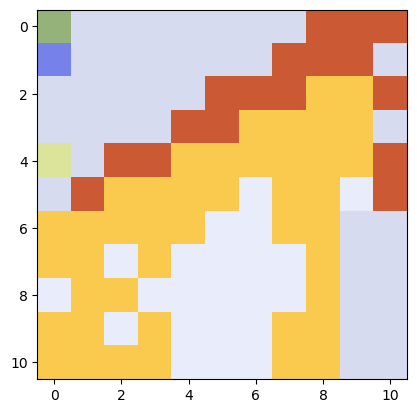

In [26]:
classes = list(set(sf_mat.reshape(-1,)))
n_class = len(classes)

colors = np.random.rand(n_class,4)
dic = {}
for i in range(n_class):
    dic[classes[i]] = colors[i]
    

img = np.zeros((num,num,4))
for i in range(num):
    for j in range(num):
        img[i][j] = dic[sf_mat[i][j]]
plt.imshow(img)

Does this mean symbolic regression is screwed? The hope is that by incorporating reasonable inductive biases (hence reducing the symbolic search space), SR will become more robust.

In [27]:
# we have used the default symbolic library whch contains the following functions
SYMBOLIC_LIB.keys()

dict_keys(['x', 'x^2', 'x^3', 'x^4', '1/x', '1/x^2', '1/x^3', '1/x^4', 'sqrt', '1/sqrt(x)', 'exp', 'log', 'abs', 'sin', 'tan', 'tanh', 'sigmoid', 'sgn', 'arcsin', 'arctan', 'arctanh', '0', 'gaussian', 'cosh'])

In [28]:
# we may constrain to a smaller library (pass as parameter "lib=lib" in suggest_symbolic)
lib = ['exp', 'x^2', 'sin']
def mix(a, b, bound=1):
    num_pts = 101
    x = torch.linspace(-bound,bound,steps=num_pts)
    x = x[:,None]
    y = a * torch.sin(x) + b * x**2 + (1-a-b) * torch.exp(x)
    dataset = {}
    dataset['train_input'] = dataset['test_input'] = x
    dataset['train_label'] = dataset['test_label'] = y
    model = KAN(width=[1,1], grid=10, k=3, seed=0, grid_range=(-bound,bound))
    model.train(dataset, opt="LBFGS", steps=20)
    return model.suggest_symbolic(0,0,0,lib=lib)[0]


In [29]:
# we can redo the analysis for a more contrained (bound) region. The phase diagram becomes even more "fractal"
num = 11
a_arr = np.linspace(0,1,num=num)
b_arr = np.linspace(0,1,num=num)
sf_mat = np.empty((num,num), dtype='U8')

for i in range(num):
    for j in range(num):
        a = a_arr[i]; b = b_arr[j]
        sf_mat[i,j] = mix(a, b, bound=0.3)

train loss: 2.17e-08 | test loss: 2.17e-08 | reg: 2.58e-01 : 100%|██| 20/20 [00:00<00:00, 45.44it/s]


function , r2
exp , 0.9999999999999639
x^2 , 0.9999841274399789
sin , 0.9999195962429422


train loss: 2.02e-08 | test loss: 2.02e-08 | reg: 2.30e-01 : 100%|██| 20/20 [00:00<00:00, 43.80it/s]


function , r2
exp , 0.9999940363902637
x^2 , 0.9999842116986534
sin , 0.9999055408903353


train loss: 1.87e-08 | test loss: 1.87e-08 | reg: 2.03e-01 : 100%|██| 20/20 [00:00<00:00, 30.85it/s]


function , r2
x^2 , 0.9999842858440444
exp , 0.9999260405306123
sin , 0.999886385951903


train loss: 1.71e-08 | test loss: 1.71e-08 | reg: 1.76e-01 : 100%|██| 20/20 [00:00<00:00, 40.10it/s]


function , r2
x^2 , 0.9999843962720248
exp , 0.9999007440044174
sin , 0.9998593570241779


train loss: 1.56e-08 | test loss: 1.56e-08 | reg: 1.50e-01 : 100%|██| 20/20 [00:00<00:00, 40.88it/s]


function , r2
x^2 , 0.9999845742894306
sin , 0.9998195334563984
exp , 0.9996560303116143


train loss: 1.41e-08 | test loss: 1.41e-08 | reg: 1.24e-01 : 100%|██| 20/20 [00:00<00:00, 37.10it/s]


function , r2
x^2 , 0.9999848839841157
sin , 0.9997576089235269
exp , 0.9990747506002051


train loss: 1.26e-08 | test loss: 1.26e-08 | reg: 9.83e-02 : 100%|██| 20/20 [00:00<00:00, 38.95it/s]


function , r2
x^2 , 0.9999854490365007
sin , 0.9996549423479186
exp , 0.9970989669443501


train loss: 1.11e-08 | test loss: 1.11e-08 | reg: 7.39e-02 : 100%|██| 20/20 [00:00<00:00, 42.44it/s]


function , r2
x^2 , 0.9999865646301423
sin , 0.9994730789192812
exp , 0.9895624276437505


train loss: 9.54e-09 | test loss: 9.54e-09 | reg: 5.21e-02 : 100%|██| 20/20 [00:00<00:00, 46.35it/s]


function , r2
x^2 , 0.9999889651827465
sin , 0.999120594481087
exp , 0.9559414617900991


train loss: 8.03e-09 | test loss: 8.03e-09 | reg: 4.00e-02 : 100%|██| 20/20 [00:00<00:00, 48.92it/s]


function , r2
x^2 , 0.9999924793158511
sin , 0.9987167102775933
exp , 0.7906888762229085


train loss: 6.57e-09 | test loss: 6.57e-09 | reg: 3.95e-02 : 100%|██| 20/20 [00:00<00:00, 34.37it/s]


function , r2
x^2 , 0.9999982519802602
sin , 0.9975488884124427
exp , 0.2695851370154267


train loss: 2.04e-08 | test loss: 2.04e-08 | reg: 2.55e-01 : 100%|██| 20/20 [00:00<00:00, 35.39it/s]


function , r2
x^2 , 0.9999897864586992
exp , 0.999941148365934
sin , 0.999933060918167


train loss: 1.88e-08 | test loss: 1.88e-08 | reg: 2.28e-01 : 100%|██| 20/20 [00:00<00:00, 36.69it/s]


function , r2
x^2 , 0.9999903651856844
exp , 0.9999481583538449
sin , 0.9999215913152464


train loss: 1.73e-08 | test loss: 1.73e-08 | reg: 2.01e-01 : 100%|██| 20/20 [00:00<00:00, 42.49it/s]


function , r2
x^2 , 0.9999910667256126
exp , 0.9999745307384252
sin , 0.9999059037181064


train loss: 1.58e-08 | test loss: 1.58e-08 | reg: 1.75e-01 : 100%|██| 20/20 [00:00<00:00, 40.01it/s]


function , r2
x^2 , 0.9999919340015667
sin , 0.9998836753524568
exp , 0.9998682812651544


train loss: 1.43e-08 | test loss: 1.43e-08 | reg: 1.49e-01 : 100%|██| 20/20 [00:00<00:00, 44.22it/s]


function , r2
x^2 , 0.9999930282260644
sin , 0.9998507984084428
exp , 0.9997376724009996


train loss: 1.28e-08 | test loss: 1.28e-08 | reg: 1.23e-01 : 100%|██| 20/20 [00:00<00:00, 42.51it/s]


function , r2
x^2 , 0.9999944249680105
sin , 0.9997993496969405
exp , 0.9992295248908697


train loss: 1.12e-08 | test loss: 1.12e-08 | reg: 9.78e-02 : 100%|██| 20/20 [00:00<00:00, 34.00it/s]


function , r2
x^2 , 0.9999962146964306
sin , 0.9997131766871225
exp , 0.9975441981216764


train loss: 9.73e-09 | test loss: 9.73e-09 | reg: 7.42e-02 : 100%|██| 20/20 [00:00<00:00, 48.14it/s]


function , r2
x^2 , 0.9999983708153872
sin , 0.9995575032145757
exp , 0.9909835169112797


train loss: 8.22e-09 | test loss: 8.22e-09 | reg: 5.33e-02 : 100%|██| 20/20 [00:00<00:00, 37.91it/s]


function , r2
x^2 , 0.9999990354001381
sin , 0.9992662822226276
exp , 0.960527319751894


train loss: 6.73e-09 | test loss: 6.73e-09 | reg: 4.04e-02 : 100%|██| 20/20 [00:00<00:00, 40.84it/s]


function , r2
x^2 , 0.9999913264861179
sin , 0.9988721445986375
exp , 0.80011712829603


train loss: 5.20e-09 | test loss: 5.20e-09 | reg: 4.08e-02 : 100%|██| 20/20 [00:00<00:00, 40.37it/s]


function , r2
x^2 , 0.9998163363479399
sin , 0.9978431561059808
exp , 0.2814546223704926


train loss: 1.90e-08 | test loss: 1.90e-08 | reg: 2.53e-01 : 100%|██| 20/20 [00:00<00:00, 43.20it/s]


function , r2
exp , 0.9999999483032596
x^2 , 0.9999941967836338
sin , 0.9999450777771645


train loss: 1.75e-08 | test loss: 1.75e-08 | reg: 2.26e-01 : 100%|██| 20/20 [00:00<00:00, 36.22it/s]


function , r2
exp , 0.9999968986658919
x^2 , 0.9999950270576494
sin , 0.9999359202086953


train loss: 1.60e-08 | test loss: 1.60e-08 | reg: 2.00e-01 : 100%|██| 20/20 [00:00<00:00, 46.59it/s]


function , r2
x^2 , 0.9999959671234449
exp , 0.9999689579268118
sin , 0.9999233338974699


train loss: 1.45e-08 | test loss: 1.45e-08 | reg: 1.73e-01 : 100%|██| 20/20 [00:00<00:00, 39.89it/s]


function , r2
x^2 , 0.9999970388609115
exp , 0.9999277672142578
sin , 0.9999054264402666


train loss: 1.30e-08 | test loss: 1.30e-08 | reg: 1.48e-01 : 100%|██| 20/20 [00:00<00:00, 43.91it/s]


function , r2
x^2 , 0.9999981866112407
sin , 0.9998787853748133
exp , 0.9997940227934969


train loss: 1.14e-08 | test loss: 1.14e-08 | reg: 1.22e-01 : 100%|██| 20/20 [00:00<00:00, 43.28it/s]


function , r2
x^2 , 0.9999993305928151
sin , 0.999836805899482
exp , 0.9993569516643317


train loss: 9.92e-09 | test loss: 9.92e-09 | reg: 9.77e-02 : 100%|██| 20/20 [00:00<00:00, 43.76it/s]


function , r2
x^2 , 0.9999999767252477
sin , 0.9997657565532695
exp , 0.9979264009346674


train loss: 8.41e-09 | test loss: 8.41e-09 | reg: 7.48e-02 : 100%|██| 20/20 [00:00<00:00, 48.04it/s]


function , r2
x^2 , 0.9999970458743549
sin , 0.9996348080941417
exp , 0.9922256134147542


train loss: 6.90e-09 | test loss: 6.90e-09 | reg: 5.51e-02 : 100%|██| 20/20 [00:00<00:00, 44.51it/s]


function , r2
x^2 , 0.9999882011585163
sin , 0.9993792035049228
exp , 0.9648688511956083


train loss: 5.37e-09 | test loss: 5.37e-09 | reg: 4.22e-02 : 100%|██| 20/20 [00:00<00:00, 40.25it/s]


function , r2
x^2 , 0.9999431478128625
sin , 0.9989853642931659
exp , 0.8099064637358544


train loss: 3.88e-09 | test loss: 3.88e-09 | reg: 4.35e-02 : 100%|██| 20/20 [00:00<00:00, 44.15it/s]


function , r2
x^2 , 0.9991878132353741
sin , 0.9979687146035487
exp , 0.2948244018433414


train loss: 1.77e-08 | test loss: 1.77e-08 | reg: 2.51e-01 : 100%|██| 20/20 [00:00<00:00, 40.99it/s]


function , r2
x^2 , 0.9999973837949323
sin , 0.9999556108208976
exp , 0.9999423526826876


train loss: 1.62e-08 | test loss: 1.62e-08 | reg: 2.25e-01 : 100%|██| 20/20 [00:00<00:00, 36.59it/s]


function , r2
x^2 , 0.9999981726743682
sin , 0.9999484842856431
exp , 0.9999473753358622


train loss: 1.47e-08 | test loss: 1.47e-08 | reg: 1.98e-01 : 100%|██| 20/20 [00:00<00:00, 44.23it/s]


function , r2
x^2 , 0.9999989595646115
exp , 0.9999492978808466
sin , 0.9999386215876175


train loss: 1.32e-08 | test loss: 1.32e-08 | reg: 1.72e-01 : 100%|██| 20/20 [00:00<00:00, 44.73it/s]


function , r2
x^2 , 0.9999996254779309
exp , 0.9999403199854738
sin , 0.9999245063324657


train loss: 1.16e-08 | test loss: 1.16e-08 | reg: 1.47e-01 : 100%|██| 20/20 [00:00<00:00, 53.99it/s]


function , r2
x^2 , 0.9999999902142925
sin , 0.9999033788427966
exp , 0.9998233862273559


train loss: 1.01e-08 | test loss: 1.01e-08 | reg: 1.22e-01 : 100%|██| 20/20 [00:00<00:00, 43.09it/s]


function , r2
x^2 , 0.9999993945260922
sin , 0.9998698461072781
exp , 0.9994604176643853


train loss: 8.60e-09 | test loss: 8.60e-09 | reg: 9.78e-02 : 100%|██| 20/20 [00:00<00:00, 40.29it/s]


function , r2
x^2 , 0.9999962624913747
sin , 0.999812394838402
exp , 0.9982470612489773


train loss: 7.09e-09 | test loss: 7.09e-09 | reg: 7.58e-02 : 100%|██| 20/20 [00:00<00:00, 39.31it/s]


function , r2
x^2 , 0.9999855256919693
sin , 0.9997042323555781
exp , 0.9934084524703305


train loss: 5.56e-09 | test loss: 5.56e-09 | reg: 5.74e-02 : 100%|██| 20/20 [00:00<00:00, 48.21it/s]


function , r2
x^2 , 0.9999509121969333
sin , 0.9994826743156423
exp , 0.9690407199009088


train loss: 4.05e-09 | test loss: 4.05e-09 | reg: 4.54e-02 : 100%|██| 20/20 [00:00<00:00, 39.78it/s]


function , r2
x^2 , 0.9998306455096987
sin , 0.9990671369324535
exp , 0.8200102819209695


train loss: 2.55e-09 | test loss: 2.55e-09 | reg: 4.76e-02 : 100%|██| 20/20 [00:00<00:00, 36.39it/s]


function , r2
x^2 , 0.9979550584268881
sin , 0.9978931765377275
exp , 0.30997176980589874


train loss: 1.64e-08 | test loss: 1.64e-08 | reg: 2.50e-01 : 100%|██| 20/20 [00:00<00:00, 40.35it/s]


function , r2
exp , 0.9999995435772306
x^2 , 0.9999993202720766
sin , 0.9999646329733246


train loss: 1.49e-08 | test loss: 1.49e-08 | reg: 2.23e-01 : 100%|██| 20/20 [00:00<00:00, 41.62it/s]


function , r2
x^2 , 0.999999776416721
exp , 0.9999936654595362
sin , 0.9999592519777621


train loss: 1.34e-08 | test loss: 1.34e-08 | reg: 1.97e-01 : 100%|██| 20/20 [00:00<00:00, 44.66it/s]


function , r2
x^2 , 0.9999999292547446
exp , 0.9999841395212624
sin , 0.999951727445816


train loss: 1.19e-08 | test loss: 1.19e-08 | reg: 1.71e-01 : 100%|██| 20/20 [00:00<00:00, 44.92it/s]


function , r2
x^2 , 0.9999996917196639
sin , 0.9999408710455521
exp , 0.9999069779386928


train loss: 1.03e-08 | test loss: 1.03e-08 | reg: 1.46e-01 : 100%|██| 20/20 [00:00<00:00, 47.71it/s]


function , r2
x^2 , 0.9999982862472424
sin , 0.999924500202756
exp , 0.9998279543178681


train loss: 8.80e-09 | test loss: 8.80e-09 | reg: 1.21e-01 : 100%|██| 20/20 [00:00<00:00, 42.92it/s]


function , r2
x^2 , 0.999994399261074
sin , 0.9998982872842133
exp , 0.9995430618744594


train loss: 7.28e-09 | test loss: 7.28e-09 | reg: 9.82e-02 : 100%|██| 20/20 [00:00<00:00, 44.87it/s]


function , r2
x^2 , 0.9999846769079466
sin , 0.9998527941960059
exp , 0.998507365877467


train loss: 5.76e-09 | test loss: 5.76e-09 | reg: 7.72e-02 : 100%|██| 20/20 [00:00<00:00, 40.42it/s]


function , r2
x^2 , 0.9999591064202273
sin , 0.9997651030691422
exp , 0.994405837621339


train loss: 4.24e-09 | test loss: 4.24e-09 | reg: 6.02e-02 : 100%|██| 20/20 [00:00<00:00, 42.98it/s]


function , r2
x^2 , 0.9998837805081656
sin , 0.9995754338853143
exp , 0.972913947729953


train loss: 2.73e-09 | test loss: 2.73e-09 | reg: 5.00e-02 : 100%|██| 20/20 [00:00<00:00, 41.06it/s]


function , r2
x^2 , 0.9996498645481074
sin , 0.9991201921166716
exp , 0.8303506225546471


train loss: 1.24e-09 | test loss: 1.24e-09 | reg: 5.35e-02 : 100%|██| 20/20 [00:00<00:00, 33.88it/s]


function , r2
sin , 0.9975671382600958
x^2 , 0.9959025139156165
exp , 0.3272398323990947


train loss: 1.51e-08 | test loss: 1.51e-08 | reg: 2.48e-01 : 100%|██| 20/20 [00:00<00:00, 33.97it/s]


function , r2
x^2 , 0.9999999273977364
sin , 0.999972137087767
exp , 0.9999416230314031


train loss: 1.36e-08 | test loss: 1.36e-08 | reg: 2.22e-01 : 100%|██| 20/20 [00:00<00:00, 40.23it/s]


function , r2
x^2 , 0.9999998145393945
sin , 0.9999682142467496
exp , 0.9999659993562859


train loss: 1.21e-08 | test loss: 1.21e-08 | reg: 1.96e-01 : 100%|██| 20/20 [00:00<00:00, 44.89it/s]


function , r2
x^2 , 0.9999990327979635
sin , 0.9999626403806093
exp , 0.9999479302673148


train loss: 1.05e-08 | test loss: 1.05e-08 | reg: 1.71e-01 : 100%|██| 20/20 [00:00<00:00, 41.24it/s]


function , r2
x^2 , 0.9999971222660284
sin , 0.9999545031184953
exp , 0.9999322662928528


train loss: 9.01e-09 | test loss: 9.01e-09 | reg: 1.46e-01 : 100%|██| 20/20 [00:00<00:00, 43.63it/s]


function , r2
x^2 , 0.9999928506457437
sin , 0.9999421177337516
exp , 0.9998097288010696


train loss: 7.49e-09 | test loss: 7.49e-09 | reg: 1.21e-01 : 100%|██| 20/20 [00:00<00:00, 44.46it/s]


function , r2
x^2 , 0.9999822360404783
sin , 0.9999220769608526
exp , 0.9996077177342251


train loss: 5.96e-09 | test loss: 5.96e-09 | reg: 9.89e-02 : 100%|██| 20/20 [00:00<00:00, 53.97it/s]


function , r2
x^2 , 0.999964802453253
sin , 0.9998867957502443
exp , 0.9987081345779585


train loss: 4.44e-09 | test loss: 4.44e-09 | reg: 7.88e-02 : 100%|██| 20/20 [00:00<00:00, 43.92it/s]


function , r2
x^2 , 0.9999175944145272
sin , 0.9998169466724585
exp , 0.9952629708219127


train loss: 2.92e-09 | test loss: 2.92e-09 | reg: 6.33e-02 : 100%|██| 20/20 [00:00<00:00, 40.19it/s]


function , r2
x^2 , 0.9997839395304963
sin , 0.9996559816500792
exp , 0.9765461190280487


train loss: 1.43e-09 | test loss: 1.43e-09 | reg: 5.57e-02 : 100%|██| 20/20 [00:00<00:00, 31.57it/s]


function , r2
x^2 , 0.9993615297170999
sin , 0.9992162433614376
exp , 0.8408048845759444


train loss: 3.44e-10 | test loss: 3.44e-10 | reg: 6.15e-02 : 100%|██| 20/20 [00:00<00:00, 23.83it/s]


function , r2
sin , 0.9969431394468133
x^2 , 0.9927325368990941
exp , 0.34705555016523576


train loss: 1.38e-08 | test loss: 1.38e-08 | reg: 2.47e-01 : 100%|██| 20/20 [00:00<00:00, 27.06it/s]


function , r2
x^2 , 0.9999993835845823
exp , 0.9999979009384041
sin , 0.9999781529177164


train loss: 1.23e-08 | test loss: 1.23e-08 | reg: 2.21e-01 : 100%|██| 20/20 [00:00<00:00, 28.15it/s]


function , r2
x^2 , 0.9999982596377558
exp , 0.9999826642402296
sin , 0.999975403004672


train loss: 1.07e-08 | test loss: 1.07e-08 | reg: 1.95e-01 : 100%|██| 20/20 [00:00<00:00, 28.02it/s]


function , r2
x^2 , 0.9999960480978767
sin , 0.9999713985665561
exp , 0.9999678693890908


train loss: 9.22e-09 | test loss: 9.22e-09 | reg: 1.70e-01 : 100%|██| 20/20 [00:00<00:00, 35.18it/s]


function , r2
x^2 , 0.999991537192374
sin , 0.999965455283627
exp , 0.9999527752253392


train loss: 7.70e-09 | test loss: 7.70e-09 | reg: 1.45e-01 : 100%|██| 20/20 [00:00<00:00, 30.27it/s]


function , r2
x^2 , 0.9999840061625307
sin , 0.9999562904170857
exp , 0.999848705695026


train loss: 6.17e-09 | test loss: 6.17e-09 | reg: 1.22e-01 : 100%|██| 20/20 [00:00<00:00, 24.01it/s]


function , r2
x^2 , 0.9999686012309674
sin , 0.9999412814570412
exp , 0.9996568552973389


train loss: 4.65e-09 | test loss: 4.65e-09 | reg: 9.98e-02 : 100%|██| 20/20 [00:00<00:00, 28.32it/s]


function , r2
x^2 , 0.999936210582381
sin , 0.999914407864863
exp , 0.998905881229885


train loss: 3.14e-09 | test loss: 3.13e-09 | reg: 8.08e-02 : 100%|██| 20/20 [00:00<00:00, 37.47it/s]


function , r2
x^2 , 0.9998600127039595
sin , 0.9998596147774699
exp , 0.9960274461980388


train loss: 1.63e-09 | test loss: 1.63e-09 | reg: 6.69e-02 : 100%|██| 20/20 [00:00<00:00, 39.89it/s]


function , r2
sin , 0.9997236129916397
x^2 , 0.9996456211560416
exp , 0.9798815731174731


train loss: 3.91e-10 | test loss: 3.91e-10 | reg: 6.21e-02 : 100%|██| 20/20 [00:00<00:00, 37.63it/s]


function , r2
sin , 0.9992448590848789
x^2 , 0.9989434205375304
exp , 0.851363652171008


train loss: 1.48e-09 | test loss: 1.48e-09 | reg: 6.99e-02 : 100%|██| 20/20 [00:00<00:00, 41.08it/s]


function , r2
sin , 0.9959631103992738
x^2 , 0.9880298934280559
exp , 0.3699525677002401


train loss: 1.25e-08 | test loss: 1.25e-08 | reg: 2.46e-01 : 100%|██| 20/20 [00:00<00:00, 37.73it/s]


function , r2
x^2 , 0.9999974755376599
sin , 0.999982771618615
exp , 0.9999378510072501


train loss: 1.10e-08 | test loss: 1.10e-08 | reg: 2.20e-01 : 100%|██| 20/20 [00:00<00:00, 46.47it/s]


function , r2
x^2 , 0.9999950949412941
sin , 0.9999809179819591
exp , 0.9999775858852623


train loss: 9.43e-09 | test loss: 9.43e-09 | reg: 1.94e-01 : 100%|██| 20/20 [00:00<00:00, 48.24it/s]


function , r2
x^2 , 0.9999909995161567
sin , 0.99997811973606
exp , 0.9999745650796973


train loss: 7.91e-09 | test loss: 7.91e-09 | reg: 1.69e-01 : 100%|██| 20/20 [00:00<00:00, 40.15it/s]


function , r2
x^2 , 0.9999839054191747
sin , 0.9999738708591638
exp , 0.9999301819009739


train loss: 6.39e-09 | test loss: 6.39e-09 | reg: 1.45e-01 : 100%|██| 20/20 [00:00<00:00, 49.67it/s]


function , r2
x^2 , 0.9999712511423499
sin , 0.9999672116732772
exp , 0.9998759476535651


train loss: 4.87e-09 | test loss: 4.87e-09 | reg: 1.22e-01 : 100%|██| 20/20 [00:00<00:00, 41.32it/s]


function , r2
sin , 0.9999561449575607
x^2 , 0.9999474340188654
exp , 0.9996925240661405


train loss: 3.36e-09 | test loss: 3.36e-09 | reg: 1.01e-01 : 100%|██| 20/20 [00:00<00:00, 37.69it/s]


function , r2
sin , 0.9999359791634311
x^2 , 0.9998987103013962
exp , 0.9990779156635234


train loss: 1.86e-09 | test loss: 1.86e-09 | reg: 8.32e-02 : 100%|██| 20/20 [00:00<00:00, 41.55it/s]


function , r2
sin , 0.999893422872044
x^2 , 0.9997851521886209
exp , 0.9966235714622826


train loss: 5.79e-10 | test loss: 5.79e-10 | reg: 7.13e-02 : 100%|██| 20/20 [00:00<00:00, 39.52it/s]


function , r2
sin , 0.9997784124877638
x^2 , 0.9994637170628504
exp , 0.9828804558908593


train loss: 1.33e-09 | test loss: 1.33e-09 | reg: 6.87e-02 : 100%|██| 20/20 [00:00<00:00, 37.55it/s]


function , r2
sin , 0.9992376323441506
x^2 , 0.9983591814967973
exp , 0.862391351818434


train loss: 2.79e-09 | test loss: 2.79e-09 | reg: 7.94e-02 : 100%|██| 20/20 [00:00<00:00, 39.73it/s]


function , r2
sin , 0.9944110485646586
x^2 , 0.9816962474224649
exp , 0.3965991904252684


train loss: 1.12e-08 | test loss: 1.12e-08 | reg: 2.45e-01 : 100%|██| 20/20 [00:00<00:00, 30.38it/s]


function , r2
x^2 , 0.9999942564460803
exp , 0.9999934337977243
sin , 0.9999861648364792


train loss: 9.65e-09 | test loss: 9.65e-09 | reg: 2.19e-01 : 100%|██| 20/20 [00:00<00:00, 35.73it/s]


function , r2
x^2 , 0.9999902923652078
sin , 0.9999849518514359
exp , 0.9999613659020306


train loss: 8.13e-09 | test loss: 8.13e-09 | reg: 1.94e-01 : 100%|██| 20/20 [00:00<00:00, 31.24it/s]


function , r2
x^2 , 0.9999837274020729
sin , 0.9999830308299852
exp , 0.9999154398628454


train loss: 6.61e-09 | test loss: 6.61e-09 | reg: 1.69e-01 : 100%|██| 20/20 [00:00<00:00, 28.46it/s]


function , r2
sin , 0.9999800294497047
x^2 , 0.9999731551293094
exp , 0.9999043625986571


train loss: 5.09e-09 | test loss: 5.09e-09 | reg: 1.45e-01 : 100%|██| 20/20 [00:00<00:00, 36.01it/s]


function , r2
sin , 0.9999752362233539
x^2 , 0.9999543237918428
exp , 0.9998837024119729


train loss: 3.59e-09 | test loss: 3.59e-09 | reg: 1.23e-01 : 100%|██| 20/20 [00:00<00:00, 33.71it/s]


function , r2
sin , 0.9999671472397126
x^2 , 0.999920520242572
exp , 0.9997162974965994


train loss: 2.11e-09 | test loss: 2.11e-09 | reg: 1.02e-01 : 100%|██| 20/20 [00:00<00:00, 29.70it/s]


function , r2
sin , 0.9999521118045746
x^2 , 0.9998517198959569
exp , 0.9991994724291818


train loss: 8.18e-10 | test loss: 8.18e-10 | reg: 8.60e-02 : 100%|██| 20/20 [00:00<00:00, 27.73it/s]


function , r2
sin , 0.9999191931580688
x^2 , 0.9996922419099825
exp , 0.9971630293162339


train loss: 1.23e-09 | test loss: 1.23e-09 | reg: 7.58e-02 : 100%|██| 20/20 [00:00<00:00, 27.04it/s]


function , r2
sin , 0.9998214259046335
x^2 , 0.9992365904461334
exp , 0.9855351478460005


train loss: 2.62e-09 | test loss: 2.62e-09 | reg: 7.77e-02 : 100%|██| 20/20 [00:00<00:00, 24.95it/s]


function , r2
sin , 0.9992094653374828
x^2 , 0.997561488327335
exp , 0.8738196605080718


train loss: 4.10e-09 | test loss: 4.10e-09 | reg: 9.07e-02 : 100%|██| 20/20 [00:00<00:00, 34.69it/s]


function , r2
sin , 0.9922364482738998
x^2 , 0.9865738449440605
exp , 0.42783037973898724


train loss: 9.87e-09 | test loss: 9.87e-09 | reg: 2.44e-01 : 100%|██| 20/20 [00:00<00:00, 48.50it/s]


function , r2
x^2 , 0.9999896926875822
sin , 0.9999885782292838
exp , 0.9999292279786546


train loss: 8.35e-09 | test loss: 8.35e-09 | reg: 2.18e-01 : 100%|██| 20/20 [00:00<00:00, 33.16it/s]


function , r2
sin , 0.9999877872886065
x^2 , 0.9999838323248553
exp , 0.9999789165976448


train loss: 6.84e-09 | test loss: 6.84e-09 | reg: 1.93e-01 : 100%|██| 20/20 [00:00<00:00, 46.33it/s]


function , r2
sin , 0.9999864664396515
x^2 , 0.9999745891023756
exp , 0.9999649555496989


train loss: 5.32e-09 | test loss: 5.32e-09 | reg: 1.69e-01 : 100%|██| 20/20 [00:00<00:00, 40.58it/s]


function , r2
sin , 0.9999843410323541
x^2 , 0.9999595824867687
exp , 0.9999363993653761


train loss: 3.83e-09 | test loss: 3.83e-09 | reg: 1.46e-01 : 100%|██| 20/20 [00:00<00:00, 41.01it/s]


function , r2
sin , 0.9999808836617524
x^2 , 0.9999340658950667
exp , 0.9998727806292239


train loss: 2.36e-09 | test loss: 2.36e-09 | reg: 1.24e-01 : 100%|██| 20/20 [00:00<00:00, 45.26it/s]


function , r2
sin , 0.9999749630672443
x^2 , 0.9998877158288519
exp , 0.9997292201760375


train loss: 1.08e-09 | test loss: 1.08e-09 | reg: 1.04e-01 : 100%|██| 20/20 [00:00<00:00, 40.71it/s]


function , r2
sin , 0.9999637514193707
x^2 , 0.9997949968711753
exp , 0.9992688918286982


train loss: 1.18e-09 | test loss: 1.18e-09 | reg: 8.91e-02 : 100%|██| 20/20 [00:00<00:00, 40.07it/s]


function , r2
sin , 0.9999382587554829
x^2 , 0.9995804083543193
exp , 0.997562547933165


train loss: 2.49e-09 | test loss: 2.49e-09 | reg: 8.13e-02 : 100%|██| 20/20 [00:00<00:00, 39.32it/s]


function , r2
sin , 0.9998545572827711
x^2 , 0.9989551972006018
exp , 0.9878365883665239


train loss: 3.94e-09 | test loss: 3.94e-09 | reg: 8.77e-02 : 100%|██| 20/20 [00:00<00:00, 41.76it/s]


function , r2
sin , 0.999179162081282
x^2 , 0.9964947779569694
exp , 0.8855949580343588


train loss: 5.41e-09 | test loss: 5.41e-09 | reg: 1.03e-01 : 100%|██| 20/20 [00:00<00:00, 44.07it/s]


function , r2
x^2 , 0.9896743802302694
sin , 0.9893409020756886
exp , 0.4646785423849215


train loss: 8.57e-09 | test loss: 8.57e-09 | reg: 2.43e-01 : 100%|██| 20/20 [00:00<00:00, 37.81it/s]


function , r2
sin , 0.9999902713620692
x^2 , 0.9999807202372036
exp , 0.9997379079627818


train loss: 7.06e-09 | test loss: 7.06e-09 | reg: 2.18e-01 : 100%|██| 20/20 [00:00<00:00, 47.32it/s]


function , r2
sin , 0.999989739250175
x^2 , 0.9999756704785013
exp , 0.999926363885015


train loss: 5.56e-09 | test loss: 5.56e-09 | reg: 1.93e-01 : 100%|██| 20/20 [00:00<00:00, 52.19it/s]


function , r2
sin , 0.9999888074224221
x^2 , 0.9999631678786869
exp , 0.9999447765899155


train loss: 4.07e-09 | test loss: 4.07e-09 | reg: 1.69e-01 : 100%|██| 20/20 [00:00<00:00, 37.65it/s]


function , r2
sin , 0.9999872737863882
x^2 , 0.9999431335080622
exp , 0.9999263142234696


train loss: 2.62e-09 | test loss: 2.62e-09 | reg: 1.46e-01 : 100%|██| 20/20 [00:00<00:00, 30.64it/s]


function , r2
sin , 0.9999847406083843
x^2 , 0.999909483042181
exp , 0.9998436631999283


train loss: 1.34e-09 | test loss: 1.34e-09 | reg: 1.25e-01 : 100%|██| 20/20 [00:00<00:00, 28.07it/s]


function , r2
sin , 0.9999803638564161
x^2 , 0.999848886198266
exp , 0.9997317587005629


train loss: 1.19e-09 | test loss: 1.19e-09 | reg: 1.06e-01 : 100%|██| 20/20 [00:00<00:00, 27.57it/s]


function , r2
sin , 0.9999719462457353
x^2 , 0.9997282247718177
exp , 0.9992837377086745


train loss: 2.37e-09 | test loss: 2.37e-09 | reg: 9.29e-02 : 100%|██| 20/20 [00:00<00:00, 29.79it/s]


function , r2
sin , 0.9999521133602743
x^2 , 0.999448434641883
exp , 0.9978756985305871


train loss: 3.79e-09 | test loss: 3.79e-09 | reg: 8.83e-02 : 100%|██| 20/20 [00:00<00:00, 43.22it/s]


function , r2
sin , 0.99988019998444
x^2 , 0.998618508248868
exp , 0.9897729427792255


train loss: 5.25e-09 | test loss: 5.25e-09 | reg: 9.97e-02 : 100%|██| 20/20 [00:00<00:00, 39.55it/s]


function , r2
sin , 0.9991252607520362
x^2 , 0.995078459413144
exp , 0.8974993831807665


train loss: 6.71e-09 | test loss: 6.71e-09 | reg: 1.16e-01 : 100%|██| 20/20 [00:00<00:00, 42.40it/s]


function , r2
x^2 , 0.9896966425177599
sin , 0.985121456003004
exp , 0.508387788052642


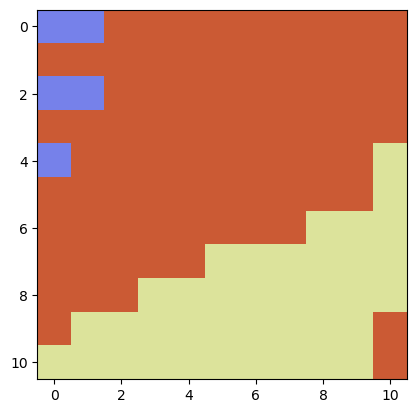

In [30]:
classes = list(set(sf_mat.reshape(-1,)))
n_class = len(classes)

colors = np.random.rand(n_class,4)
dic = {}
for i in range(n_class):
    dic[classes[i]] = colors[i]
    

img = np.zeros((num,num,4))
for i in range(num):
    for j in range(num):
        img[i][j] = dic[sf_mat[i][j]]
plt.imshow(img)